# Blindaje de Gammas y Betas

Simula la atenuación de fotones y betas por una pared de espesor variable 
Basado en ThicknessScan de K. Sjobak (October 23rd 2018, January 2019)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ROOT

# %matplotlib notebook

# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 120
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

#Setup MiniScatter
import sys
MiniScatter_path="/opt/MiniScatter/build"
sys.path.append(MiniScatter_path)
#import CLEARview

import miniScatterDriver
import miniScatterScanner

Welcome to JupyROOT 6.20/02


In [2]:
### Parameters for radiation length calculation ###

# Element data from PDG
# http://pdg.lbl.gov/2018/AtomicNuclearProperties/index.html
A = {} #[g/mole]
Z = {} #[e]
dens = {} #[g/cm3]

# http://pdg.lbl.gov/2009/reviews/rpp2009-rev-atomic-nuclear-prop.pdf
radLen = {} #[g/cm^2]


A   ["Al"] = 26.9815385
Z   ["Al"] = 13
dens["Al"] = 2.699

A   ["Pb"] = 207.2
Z   ["Pb"] = 82
dens["Pb"] = 11.35


def computeX0(elem):
    #Computes in the radiation length in g/cm^2
    if not elem in A:
        return radLen[elem]
    
    return (716.4 * A[elem]) / \
        ( Z[elem] * (Z[elem]+1) * np.log(287.0/np.sqrt(Z[elem])) )
def computeL(elem):
    #Computes the radiation length in mm
    return 10*computeX0(elem)/dens[elem]
def printRadLenData(elem):
    print(elem+":", computeX0(elem),"[g/cm^2] -> ", computeL(elem),"[mm]")

printRadLenData("Al")

Al: 24.26462615100901 [g/cm^2] ->  89.90228288628757 [mm]


In [3]:
### Basic simulation parameters ###

NUM_THREADS = 1
QUIET = False
TRYLOAD = False #Try to load already existing data instead of recomputing?
TMPFOLDER = "/tmp/miniScatter/PLE_thicknessScan"

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS"
baseSimSetup["PHYS"] = "QGSP_BERT"

baseSimSetup["N"] = 500 #number of simulated particles emited by the source

baseSimSetup["ZOFFSET"]           = 0.0 #Auto

baseSimSetup["DIST"] = 100.0 #Detector distance from target center [mm] 

baseSimSetup["QUICKMODE"] = True #Skip verification plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files

#Cutoffs for _cutoff analyses
baseSimSetup["CUTOFF_ENERGYFRACTION"] = 0.5
baseSimSetup["CUTOFF_RADIUS"] = 100.0 #[mm]


thickScan_radLen=np.logspace(-3, 1.0, 30)

In [4]:
def showYield_singleSim(thickScan,numPart,N,p_type):
    '''
    Function to plot the results from the simulation. 
    It allow to plot different particles depending on the source type (gamma or betas)
    '''
    plt.figure()
    
    
    if p_type == 'gamma':
     
        plt.title("Photons")
        plt.plot(thickScan,numPart["tracker"][22]/N,'bo', label="tracker") # 22 -> pdg ID to identify photons
        plt.legend(loc='upper right')
        plt.xlabel('Target thickness [mm]')
        plt.ylabel('$N_{out}/N_{original}$')
       

    if p_type == 'e':
        plt.subplot(1,2,1)
        
        plt.title("Photons")
        plt.plot(thickScan,numPart["tracker"][22]/N,'bo', label="tracker")
        plt.subplot(1,2,2)
    
        plt.title("Surviving positrons and electrons")
        
        plt.plot(thickScan,numPart["tracker" ][11]/N,'mo', label="e-") # 11 -> pdg ID to identify electrons
        plt.plot(thickScan,numPart["tracker" ][-11]/N,'bo', label="e+")
        plt.legend(loc='upper right')
        plt.xlabel('Target thickness [mm]')
        

LoadFile filename and status: 'SaveSim_THICK_TargetThickness-Pb-100MeV-gamma.h5' False
THICK = 0.1 (1/8)
creating log ./log/
Running command line: './MiniScatter -t 0.1 -m G4_Pb -d 100.0 -p QGSP_BERT -n 500 -e 1 -b gamma -z 0.0 -s 1 -f output_THICK=0.1 -o /tmp/miniScatter/PLE_thicknessScan -q -r --cutoffEnergyFraction 0.5 --cutoffRadius 100.0'

Done!
Deleting '/tmp/miniScatter/PLE_thicknessScan/output_THICK=0.1.root'.
THICK = 5.1 (2/8)
creating log ./log/
Running command line: './MiniScatter -t 5.1 -m G4_Pb -d 100.0 -p QGSP_BERT -n 500 -e 1 -b gamma -z 0.0 -s 2 -f output_THICK=5.1 -o /tmp/miniScatter/PLE_thicknessScan -q -r --cutoffEnergyFraction 0.5 --cutoffRadius 100.0'

Done!
Deleting '/tmp/miniScatter/PLE_thicknessScan/output_THICK=5.1.root'.
THICK = 10.1 (3/8)
creating log ./log/
Running command line: './MiniScatter -t 10.1 -m G4_Pb -d 100.0 -p QGSP_BERT -n 500 -e 1 -b gamma -z 0.0 -s 3 -f output_THICK=10.1 -o /tmp/miniScatter/PLE_thicknessScan -q -r --cutoffEnergyFraction 0.5 --c

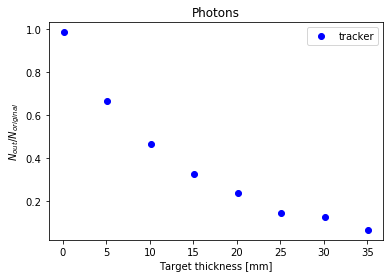

In [6]:
# Exaple on how to launch gamma with energy 1 MeV on a lead target
baseSimSetup_Pb = baseSimSetup.copy()
baseSimSetup_Pb["BEAM"] = "gamma" #type of particle ("e+" for betas)
baseSimSetup_Pb["MAT"] = "G4_Pb" #target material
baseSimSetup_Pb["ENERGY"] = 1 # Energy of the beam in MeV, is a pencil beam 


thickScan_Pb =np.arange(0.1,40,5) #scan in differentes vaules of the material thikness

#run the simulation or load file if simulation already runned 
(twiss_Pb, numPart_Pb, objects_Pb, analysis_output_Pb) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_Pb,baseSimSetup_Pb, \
                                       NUM_THREADS=1,tryLoad=TRYLOAD,\
                                       COMMENT="TargetThickness-Pb-100MeV-gamma", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER)

#plotting
showYield_singleSim(thickScan_Pb,numPart_Pb,baseSimSetup_Pb["N"],p_type='gamma')

plt.show()